In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import jax
from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey
from jax import lax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

## Deterministic model

In [3]:
def dx_dt(x, t, beta, gamma):
    """
    SIR equations. Real positive parameters `beta`, `gamma`,
    describe the infection rate and recovery rate.
    Also tracks new infections.
    """
    S = x[0]
    I = x[1]
    R = x[2]
    n = S + I + R
    I_tot = x[3]
    dS_dt = - beta * S * I / n
    dI_dt = beta * S * I / n - gamma * I
    dR_dt = gamma * I
    dItot_dt = beta * S * I / n
    return np.stack([dS_dt, dI_dt, dR_dt, dItot_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)

def SIR_deterministic(ts, beta=2.2/10, gamma=1.0/10, N=1e6, I_frac=0.001):
    x_init = N*np.array([1-I_frac, I_frac, 0, 0])
    theta = np.array([beta, gamma])
    return SIR_int(x_init, ts, *theta)

def test_SIR_deterministic():
    ts = np.linspace(0.0, 200.0, 100)

    gamma = 1/10
    
    R0_vals = [1.5, 2.5, 3.5]
    colors = ['r', 'b', 'orange']

    plt.figure(figsize=(8,5))
    for R0, color in zip(R0_vals, colors):
        beta = R0*gamma
        x = SIR_deterministic(ts, beta, gamma, N=1e3)
        plt.plot(ts, x[:,1], color=color, linestyle='-')
        plt.plot(ts, x[:,2], color=color, linestyle='--')
        
    plt.legend(plt.gca().lines[::2], R0_vals)
    plt.show()

#test_SIR_deterministic()
    

## Current model: SIR model for new cases with random parameters/observations, deterministic dynamics


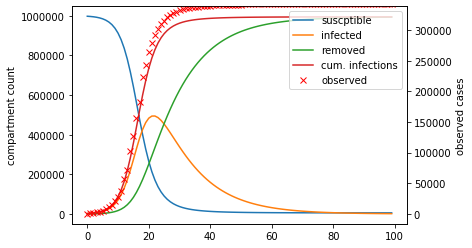

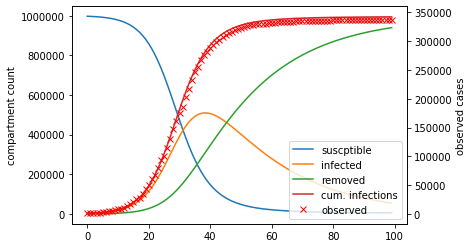

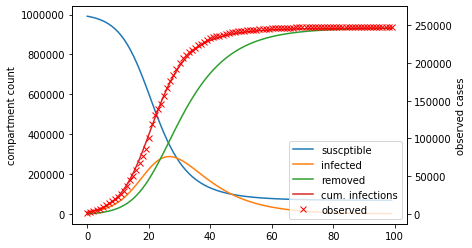

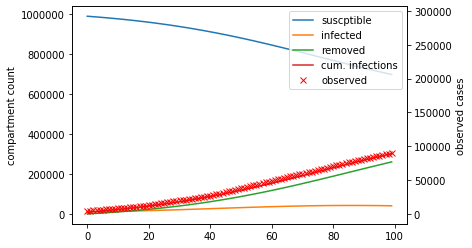

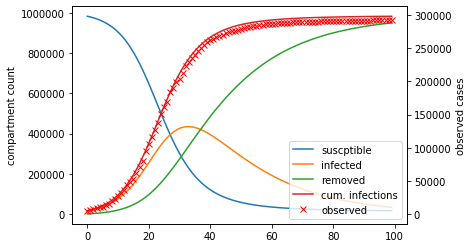

In [11]:
def SIR_hybrid(T = 50, 
               N = 1e5, 
               duration_mean = 10,
               R0_mean = 2.2,
               gamma_shape = 5,
               beta_shape = 5,
               det_rate_mean = 0.3,
               det_rate_conc = 100,
               det_noise = 0.1,
               new_cases = None):

    # Sample initial fraction of infected individuals
    I_init = numpyro.sample("I_init", dist.Uniform(0, 0.02))

    # Sample parameters
    gamma = numpyro.sample("gamma", 
                           dist.Gamma(gamma_shape, gamma_shape * duration_mean))
    
    beta = numpyro.sample("beta", 
                          dist.Gamma(beta_shape, beta_shape * duration_mean/R0_mean))

    det_rate = numpyro.sample("det_rate", 
                              dist.Beta(det_rate_mean * det_rate_conc,
                                        (1-det_rate_mean) * det_rate_conc))

    # Run simultation using ODE solve
    x_init = N * np.array([1-I_init, I_init, 0.0, I_init])
    ts = np.arange(0, T, 1.0)
    x = SIR_int(x_init, ts, beta, gamma)    
    numpyro.deterministic("x", x)
        
    # Compute number of new infections in each time step
    new_infections = np.diff(np.hstack((0, x[:,3])))

    # Generate actual observations on observed time steps
    if False:    
        y = numpyro.sample("y", 
                           dist.Normal(loc = new_infections * det_rate, 
                                       scale = new_infections * det_noise),
                           obs=new_cases)
    else:
        conc = 50
        alpha = det_rate * conc * np.ones(T)
        beta = (1-det_rate) * conc * np.ones(T)
        d = dist.TransformedDistribution(dist.Beta(alpha, beta),
                                         dist.transforms.AffineTransform(0, scale=new_infections))

        y = numpyro.sample("y", d, obs=new_cases)
        
    return x, y, det_rate

def test_hybrid(i, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        x, y, obs_rate = SIR_hybrid(**kwargs)

    T = len(y)
    ts = np.arange(T)
    
    y_cum = np.cumsum(y)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)
    
    l2 = ax2.plot(ts, y_cum, 'x', color='r')
    
    plt.legend(l1 + l2, ['suscptible', 'infected', 'removed', 'cum. infections', 'observed'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

for i in range(5):
    test_hybrid(i, T=100, N=1e6)

In [7]:
def plot_samples(samples, legend=True, T=None, plot_fields=['I', 'y'], ax1=None, ax2=None):
    
    T_data = samples['x'].shape[1]
    if T is None or T > T_data:
        T = T_data

    ts = np.arange(T)
    
    X = samples['x']
    
    fields = {'S': (X[:,:T,0], 'suceptible', 'black'),
              'I': (X[:,:T,1], 'infected', 'red'),
              'R': (X[:,:T,2], 'removed', 'blue'),
              'C': (X[:,:T,3], 'total infected', 'green')}
    
    
    if 'y' in samples:
        fields['y'] = (np.nancumsum(samples['y'][:,:T], axis=1), 'observed', 'orange')
    
    fields = {k: fields[k] for k in plot_fields}
    
    lines = []
    labels = []
    
    if ax1 is None:
        ax1 = plt.gca()

    ax1.set_ylabel('number of people')
        
    if ax2 is not None:
        ax2.set_ylabel('number observed')
        
    for key, val in fields.items():
        data, label, color = val
        
        mean = data.mean(axis=0)
        pred_interval = np.percentile(data, (10, 90), axis=0)

        ax = ax2 if key=='y' and ax2 is not None else ax1            
        
        l = ax.plot(ts, mean, color=color)
        ax.fill_between(ts, pred_interval[0, :], pred_interval[1, :], color=color, alpha=0.1)
        
        lines += l
        labels += [label]
        
    
    if legend:
        plt.legend(lines, labels)

    return lines, labels

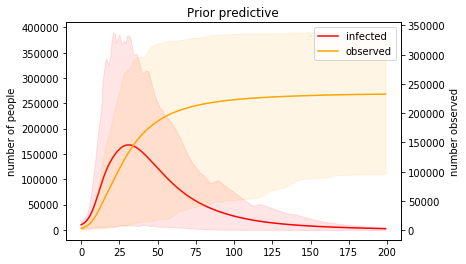

In [991]:
T = 200
N = 1e6
predictive = Predictive(SIR_hybrid, 
                        posterior_samples = {}, 
                        num_samples=100)

samples = predictive(PRNGKey(2), T=T, N=N)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plot_samples(samples, ax1=ax1, ax2=ax2)

plt.title('Prior predictive')
plt.show()

In [513]:
def load_us():
    df = pd.read_csv('us-daily.csv')
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    df = df.set_index('date')
    df = df.sort_index()
    return df.positive

def load_state(state='MA'):
    df = pd.read_csv('states-daily.csv')
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    df = df.set_index('date')
    df = df.sort_index()
    return df[df.state==state].positive.sort_index()

In [12]:
import jhu

US = jhu.load_us()

pop = {
    'tot': 3.27e8,
    'MA': 6.902e6,
    'WA': 7.536e6
}

place = 'MA'

start = pd.Timestamp('2020-03-01')

positive = US[place].confirmed[start:]
N = pop[place]

new_cases = np.array(np.diff(positive))

kernel = NUTS(SIR_hybrid)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)

T = len(new_cases)

init = {
    'I_init': 0.01,
    'gamma': 1/10.0,
    'beta': 2.5/10.0,
    'det_rate' : 0.3
}

mcmc.run(jax.random.PRNGKey(1), N=N, T=T, new_cases=new_cases, init_params=init)
mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:29<00:00, 67.12it/s, 31 steps of size 1.19e-01. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    I_init      0.00      0.00      0.00      0.00      0.00    426.68      1.00
      beta      0.45      0.04      0.45      0.39      0.52    374.97      1.00
  det_rate      0.12      0.02      0.12      0.09      0.15    430.11      1.00
     gamma      0.08      0.04      0.08      0.03      0.14    440.02      1.00

Number of divergences: 0


In [13]:
# Visualize posterior predictive samples
T = 200
post_pred = Predictive(SIR_hybrid, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T=T, N=N)

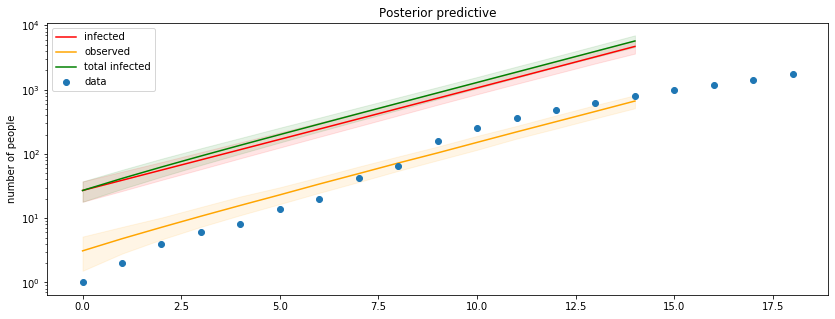

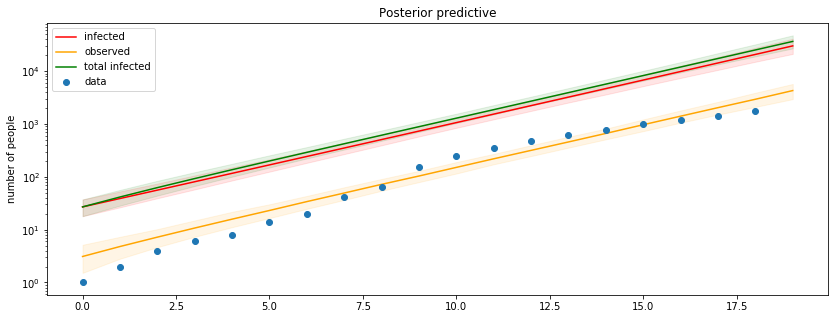

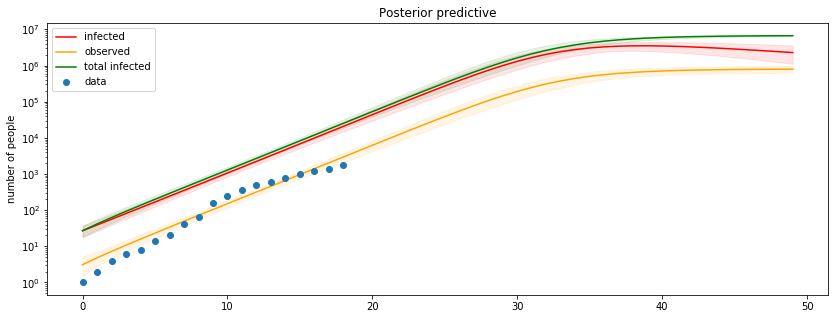

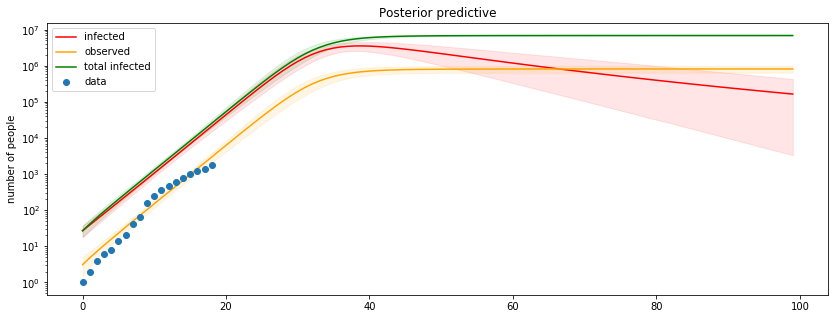

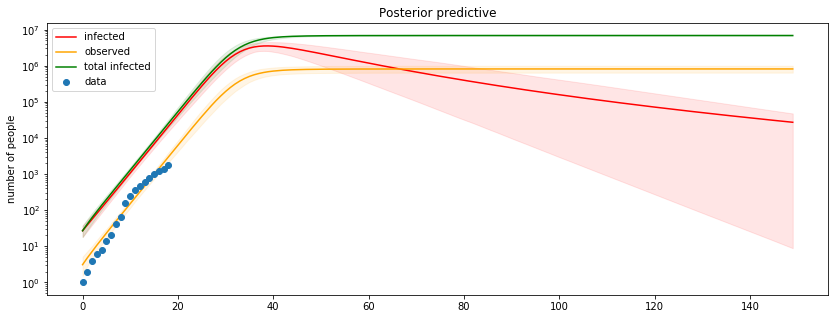

In [14]:
scale = 'log'

for T in [15, 20, 50, 100, 150]:
    
    fig, ax1 = plt.subplots(figsize=(14,5))
    lines, labels = plot_samples(post_pred_samples, T=T, plot_fields=['I', 'y', 'C'])
    plt.title('Posterior predictive')
    
    l = plt.plot(np.cumsum(new_cases), 'o')
    plt.legend(lines + l, labels + ['data'])

    if scale == 'log':
        plt.yscale('log')
        
    filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    plt.savefig(filename)
        
    plt.show()

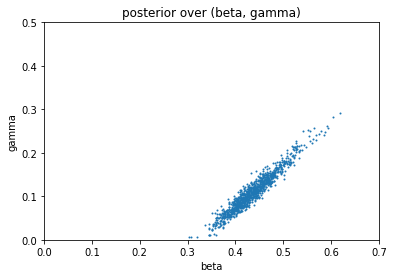

R0: 4.7577605


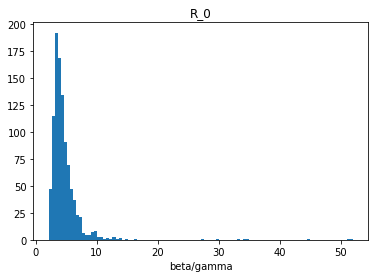

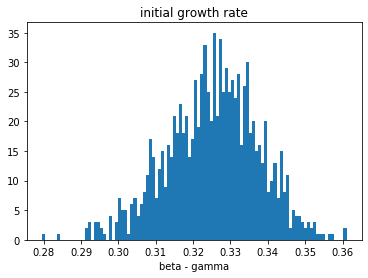

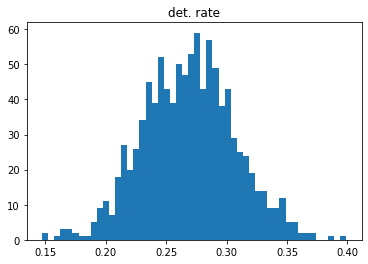

In [1009]:
save = False

beta = mcmc_samples['beta']
gamma = mcmc_samples['gamma']
plt.scatter(beta, gamma, s=1)
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.xlim([0, 0.7])
plt.ylim([0, 0.5])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = mcmc_samples['beta'] - mcmc_samples['gamma']
plt.hist(growth_rate, bins=100)
plt.title('initial growth rate')
plt.xlabel('beta - gamma')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


(0, 2e-05)

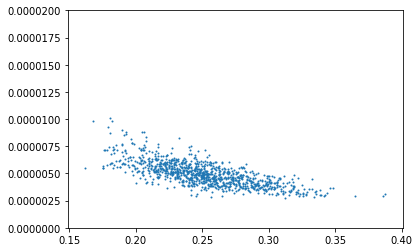

In [1000]:
plt.scatter(mcmc_samples['det_rate'], mcmc_samples['I_init'], s=1)
plt.ylim([0, 0.00002])

## Old: stochastic dynamics

In [4]:
def SIR_stochastic(dt = 1.0, 
                   steps = 50,
                   N = 1e5,
                   I_frac=0.05,
                   duration_mean=10,
                   duration_scale_factor=0.5,
                   R0_mean=2.2,
                   R0_scale_factor=0.2,
                   obs_rate=0.3,
                   obs_conc=50,
                   SI_conc=50,
                   IR_conc=50,
                   dynamics="Beta"):
    
    x_init = N*np.array([1-I_frac, I_frac, 0])
    N = x_init.sum()
    
    duration = numpyro.sample(
        "duration", 
        dist.TruncatedNormal(low=0.,
                             loc=duration_mean, 
                             scale=duration_mean*duration_scale_factor))
    
    R0 = numpyro.sample("R0",
                        dist.TruncatedNormal(low=0.,
                                             loc=R0_mean,
                                             scale=R0_scale_factor))
    
    gamma = 1./duration    
    beta = R0 * gamma
    
    numpyro.deterministic("beta", beta)
    numpyro.deterministic("gamma", gamma)
        
    j = 0
    def advance(x, ignore):
        nonlocal j

        S, I, R = x
        
        rate_SI = beta * I / N
        rate_IR = gamma

        p_SI = 1 - np.exp(-rate_SI * dt)
        p_IR = 1 - np.exp(-rate_IR * dt)
                

        if dynamics=="Binomial":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Binomial(S, p_SI))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Binomial(I, p_IR))
        
        elif dynamics=="Beta":
            n_SI = S * numpyro.sample(f'n_SI_{j}', dist.Beta(p_SI * SI_conc, 
                                                             (1-p_SI) * SI_conc))
            n_IR = I * numpyro.sample(f'n_IR_{j}', dist.Beta(p_IR * SI_conc, 
                                                             (1-p_IR) * IR_conc))

        elif dynamics=="Poisson":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Poisson(S * rate_SI * dt))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Poisson(I * rate_IR * dt))
            
        else:
            raise ValueError("Bad dynamics")
        
        j = j + 1
        
        delta = np.array([n_SI, n_IR])
        flow = np.array([-n_SI, n_SI - n_IR, n_IR])
        x_new = x + flow

        return x_new, (x_new, delta)

    _, STATE = lax.scan(advance, x_init, None, steps)
    X, delta = STATE
    
    X = np.vstack([x_init, X])
    
    n_SI = delta[:,0]
    numpyro.deterministic("X", X)
    
    y = n_SI * numpyro.sample('obs_frac', 
                              dist.Beta(obs_rate*obs_conc,
                                        (1-obs_rate)*obs_conc),
                              sample_shape=(steps,))
    
    numpyro.deterministic("y", y)

    return X, y

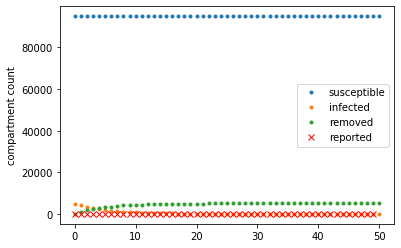

In [6]:
with numpyro.handlers.seed(rng_seed=6):
    X, y = SIR_stochastic(dt=1.0, steps=50, N=1e5)

y = np.cumsum(y)
fig, ax1 = plt.subplots(figsize=(6,4))

l1 = ax1.plot(X, '.')
ax1.set_ylabel('compartment count')

plotyy = False
if plotyy:
    ax2 = ax1.twinx()
    l2 = ax2.plot(y, 'x', color='r')    
    ax2.set_ylabel('confirmed cases', color='r')
    ax2.spines['right'].set_color('r')
    ax2.yaxis.label.set_color('r')
    ax2.tick_params(axis='y', colors='r')
else:
    l2 = ax1.plot(y, 'x', color='r')

plt.legend(l1 + l2, ['susceptible', 'infected', 'removed', 'reported'])

plt.show()

## Scratch

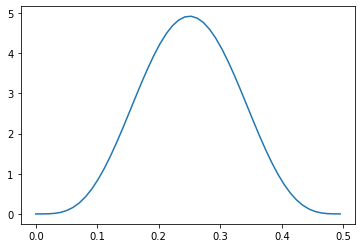

In [987]:
d = dist.TransformedDistribution(dist.Beta(5,5), 
                                 dist.transforms.AffineTransform(0, scale=0.5))

x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(d.log_prob(x)))
plt.show()